<a href="https://colab.research.google.com/github/SurajDeSilva/PINNs-For-Non-Linear-Odes/blob/main/PINNs_Forward_and_Inverse_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Genarate Training Data

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the differential equation
def damped_harmonic_oscillator(t, y, m, mu, k):
    dxdt = y[1]
    dvdt = -(mu/m) * y[1] - (k/m) * y[0]
    return [dxdt, dvdt]

# Parameters
m = 2  # Mass (kg)
mu = 0.3  # Damping coefficient
k = 0.2  # Spring constant

# Initial conditions: [initial displacement, initial velocity]
y0 = [1, 0]

# Generate training data over the range [0, 30] with 100 points
t_train_eval = np.linspace(0,30, 100)
solution_train = solve_ivp(
    damped_harmonic_oscillator,
    (0,30),
    y0,
    args=(m, mu, k),
    t_eval=t_train_eval,
    method='RK45'
)

train_df = pd.DataFrame({'Time': solution_train.t, 'Displacement': solution_train.y[0],'Velocity': solution_train.y[1]})

## Genarate Tesing Data

In [2]:
# Generate testing data over the range [0, 60] with 120 different points
t_test_eval = np.linspace(0,60,120)
solution_test = solve_ivp(
    damped_harmonic_oscillator,
    (0, 60),
    y0,
    args=(m, mu, k),
    t_eval=t_test_eval,
    method='RK45'
)
test_df = pd.DataFrame({'Time': solution_test.t, 'Displacement': solution_test.y[0],'Velocity': solution_test.y[1]})

## Plot Trainig and Testing Data

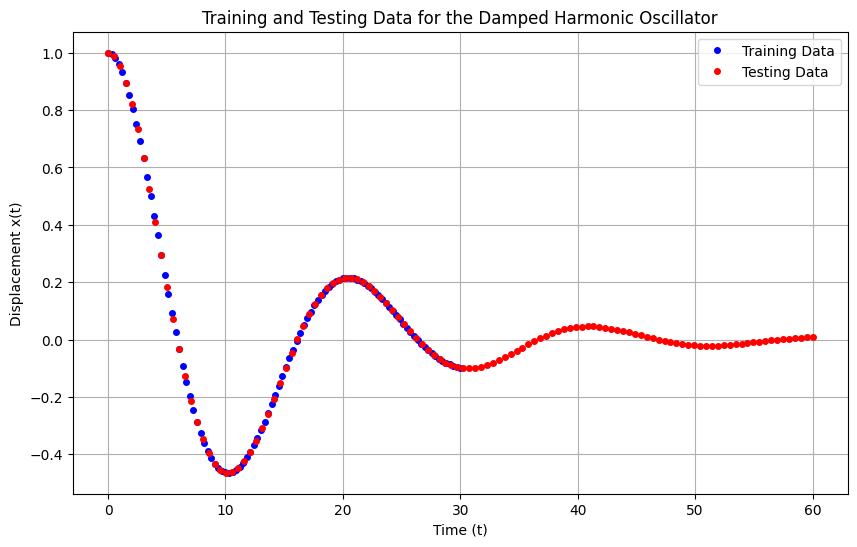

In [3]:
# Plot training and testing data
plt.figure(figsize=(10, 6))
plt.plot(train_df['Time'], train_df['Displacement'], 'bo', label='Training Data', markersize=4)
plt.plot(test_df['Time'], test_df['Displacement'], 'ro', label='Testing Data', markersize=4)
plt.xlabel('Time (t)')
plt.ylabel('Displacement x(t)')
plt.title('Training and Testing Data for the Damped Harmonic Oscillator')
plt.legend()
plt.grid()
plt.show()

##Forward Solution

In [4]:
# Convert to tensors
t_train_tensor = torch.tensor(train_df['Time'].values, dtype=torch.float32).view(-1, 1)
x_train_tensor = torch.tensor(train_df['Displacement'].values, dtype=torch.float32).view(-1, 1)
t_test_tensor = torch.tensor(test_df['Time'].values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(test_df['Displacement'].values, dtype=torch.float32).view(-1, 1)

Epoch 0: Loss = 194.409683, Learning Rate = 0.001000
Epoch 1000: Loss = 0.005918, Learning Rate = 0.000500
Epoch 2000: Loss = 0.001643, Learning Rate = 0.000250
Epoch 3000: Loss = 0.000163, Learning Rate = 0.000125
Epoch 4000: Loss = 0.000002, Learning Rate = 0.000063
Epoch 5000: Loss = 0.000020, Learning Rate = 0.000063
Epoch 6000: Loss = 0.000001, Learning Rate = 0.000031
Epoch 7000: Loss = 0.000002, Learning Rate = 0.000031
Epoch 8000: Loss = 0.000001, Learning Rate = 0.000016
Epoch 9000: Loss = 0.000001, Learning Rate = 0.000016
Epoch 10000: Loss = 0.000001, Learning Rate = 0.000008
Epoch 11000: Loss = 0.000001, Learning Rate = 0.000008
Epoch 12000: Loss = 0.000001, Learning Rate = 0.000008
Epoch 13000: Loss = 0.000002, Learning Rate = 0.000008
Epoch 14000: Loss = 0.000001, Learning Rate = 0.000004
Epoch 15000: Loss = 0.000001, Learning Rate = 0.000004
Epoch 16000: Loss = 0.000001, Learning Rate = 0.000004
Epoch 17000: Loss = 0.000001, Learning Rate = 0.000004
Epoch 18000: Loss = 0

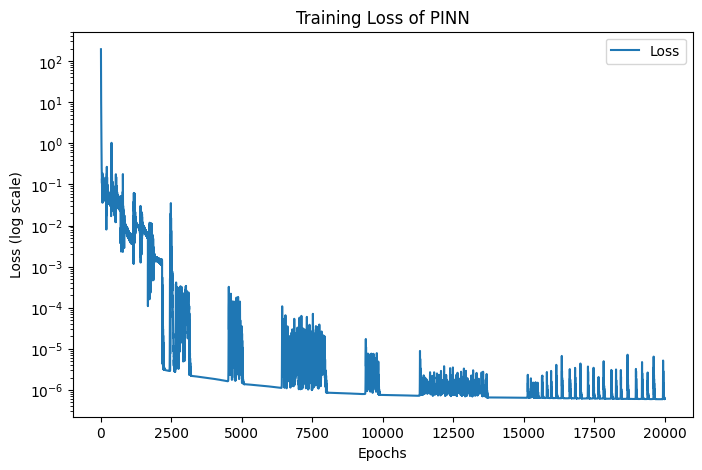

In [5]:
# Define the PINN model
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 128),
            Sine(),
            nn.Linear(128, 128),
            Sine(),
            nn.Linear(128, 128),
            Sine(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def forward(self, t):
        return self.hidden(t)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, -np.sqrt(6 / m.in_features), np.sqrt(6 / m.in_features))

# Define the data loss function
def data_loss(model, t, x):
    x_pred = model(t)
    return torch.mean((x_pred - x) ** 2)

# Define the physics-informed loss function
def physics_loss(model, t):
    t = t.requires_grad_(True)
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    f = 2 * d2x_dt2 + 0.3 * dx_dt + 0.2 * x
    return torch.mean(f**2)

# Train the model
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, min_lr=1e-6)

# Training loop
num_epochs = 20000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss_pde = physics_loss(model, t_train_tensor)
    loss_data = data_loss(model, t_train_tensor, x_train_tensor)
    loss = 0.1 * loss_data + 1.0 * loss_pde  # Combine physics and data loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)
    loss_history.append(loss.item())
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Learning Rate = {optimizer.param_groups[0]['lr']:.6f}")

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss of PINN')
plt.legend()
plt.show()

## Forward Solution for In range Testing and Out of Range testing

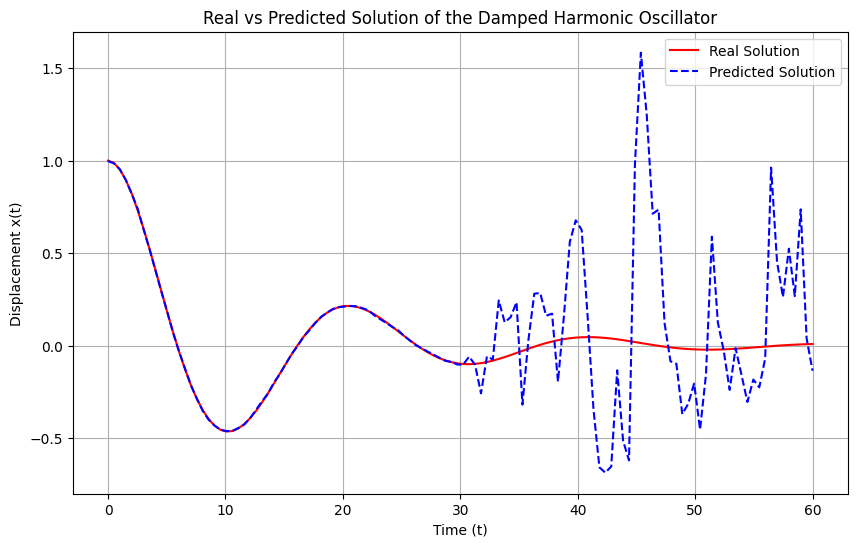

In [6]:
# Evaluate the trained model on the test data
x_pred = model(t_test_tensor).detach().numpy()
test_df['PINN_Solution_Predicted_Displacement'] = x_pred

# Plot real vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test_df['Time'], test_df['Displacement'], label='Real Solution', color='red')
plt.plot(test_df['Time'], x_pred, label='Predicted Solution', color='blue', linestyle='dashed')
plt.xlabel('Time (t)')
plt.ylabel('Displacement x(t)')
plt.title('Real vs Predicted Solution of the Damped Harmonic Oscillator')
plt.legend()
plt.grid()
plt.show()

## Inverse Solution

In [7]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.0 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import optuna
import matplotlib.pyplot as plt
import pandas as pd

# Define the neural network
class NN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        self.encode = nn.Sequential(nn.Linear(n_input, n_hidden), nn.Tanh())
        self.hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.Tanh()) for _ in range(n_layers - 1)])
        self.decode = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.encode(x)
        x = self.hidden(x)
        x = self.decode(x)
        return x

# Plot predictions
def plot_predictions(i, t, x, xh, estimated_params, loss):
    title_params = ", ".join([f"{key}={val:.5f}" for key, val in estimated_params.items()])
    plt.figure(figsize=(6, 4))
    plt.plot(t.detach().numpy(), x.detach().numpy(), "o-", label="Exact X", color="steelblue", markersize=4)
    plt.plot(t.detach().numpy(), xh.detach().numpy(), "o--", label="Predicted X", color="darkorange", markersize=4)
    plt.title(f"Predictions at Step {i}\n{title_params}, Loss={loss:.5f}")
    plt.xlabel("Time (t)")
    plt.ylabel("Displacement (X)")
    plt.legend()
    plt.grid(visible=True, which="major", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot losses
def plot_losses(losses, steps, loss_type="Loss"):
    plt.figure(figsize=(6, 4))
    plt.plot(steps, losses, "b-", label=f"{loss_type}")
    plt.title(f"{loss_type} over Training Steps")
    plt.xlabel("Training Steps")
    plt.ylabel(loss_type)
    plt.grid(visible=True, which="major", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Physics-Informed Neural Network training function
def pinn_training(t, x, fixed_params, n_hidden, n_layers, epochs, lambda1, learning_rate, plot=False):
    torch.manual_seed(123)
    model = NN(n_input=1, n_output=1, n_hidden=n_hidden, n_layers=n_layers)

    # Define trainable and fixed parameters
    trainable_params = {}
    for param in ['m', 'mu', 'k']:
        if param in fixed_params:
            trainable_params[param] = torch.tensor(fixed_params[param], dtype=torch.float32, requires_grad=False)
        else:
            trainable_params[param] = torch.rand(1, requires_grad=True)

    parameters = list(model.parameters()) + [p for p in trainable_params.values() if p.requires_grad]
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)

    t_physics = torch.linspace(t.min().item(), t.max().item(), steps=5000, dtype=torch.float32).view(-1, 1).requires_grad_(True)

    # Lists to store loss values
    data_losses = []
    physics_losses = []
    total_losses = []
    steps = []

    for i in range(epochs + 1):
        optimizer.zero_grad()

        # Data loss
        xh = model(t)
        data_loss = torch.mean((xh - x) ** 2)

        # Physics loss
        xhp = model(t_physics)
        dxdt = torch.autograd.grad(xhp, t_physics, torch.ones_like(xhp), create_graph=True)[0]
        d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
        physics_loss = torch.mean((trainable_params['m'] * d2xdt2.flatten() +
                                   trainable_params['mu'] * dxdt.flatten() +
                                   trainable_params['k'] * xhp.flatten()) ** 2)

        # Total loss
        loss = data_loss + lambda1 * physics_loss
        loss.backward()
        optimizer.step()

        # Store losses and steps
        if i % 10 == 0 or i == epochs:
            data_losses.append(data_loss.item())
            physics_losses.append(physics_loss.item())
            total_losses.append(loss.item())
            steps.append(i)

        # Plot predictions every 100 steps and at the final step
        if plot and (i % 100 == 0 or i == epochs):
            xh = model(t).detach()
            estimated_values = {k: v.item() for k, v in trainable_params.items() if v.requires_grad}
            plot_predictions(i, t, x, xh, estimated_values, loss.item())

    if plot:
        # Plot loss curves
        plot_losses(data_losses, steps, "Data Loss")
        plot_losses(physics_losses, steps, "Physics Loss")
        plot_losses(total_losses, steps, "Total Loss")

    return loss.item(), {k: v.item() for k, v in trainable_params.items() if v.requires_grad}

# Hyperparameter tuning with Optuna
def objective(trial):
    # Sample hyperparameters
    n_hidden = trial.suggest_int("n_hidden", 4, 32)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    lambda1 = trial.suggest_loguniform("lambda1", 1e-4, 1e-1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Run training with sampled hyperparameters
    final_loss, _ = pinn_training(t, x, fixed_params, n_hidden=n_hidden, n_layers=n_layers, epochs=500, lambda1=lambda1, learning_rate=learning_rate, plot=False)

    return final_loss  # Minimize this loss


df = train_df[["Time", "Displacement"]]
t = torch.tensor(df["Time"].values, dtype=torch.float32).view(-1, 1)
x = torch.tensor(df["Displacement"].values, dtype=torch.float32).view(-1, 1)

# Example 1: Fix k, estimate m & mu
#fixed_params = {"k": 1.0}

# Example 2: Fix m, estimate mu & k
fixed_params = {"m": 2}

# Example 3: Fix mu, estimate m & k
# fixed_params = {"mu": 0.5}

# Example 4: Fix both m and k, estimate mu only
# fixed_params = {"m": 1.0, "k": 1.0}



In [ ]:
print("🔍 Finding best hyperparameters...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters

# Best hyperparameters
best_params = study.best_params
print(f"✅ Best Hyperparameters: {best_params}")

📈 Training final model with best parameters and plotting results...


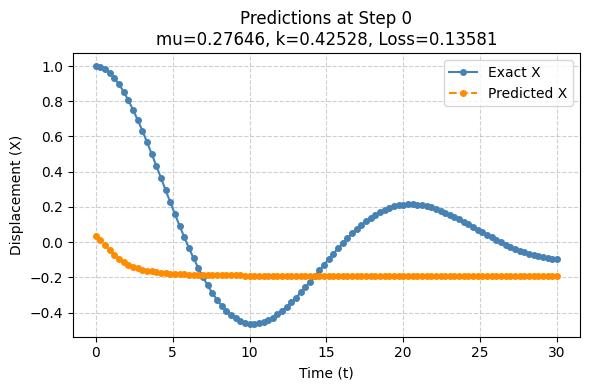

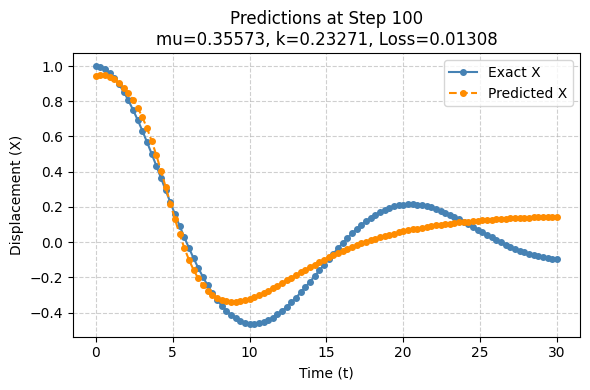

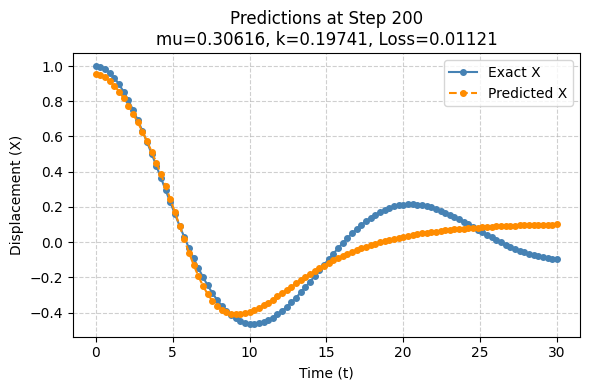

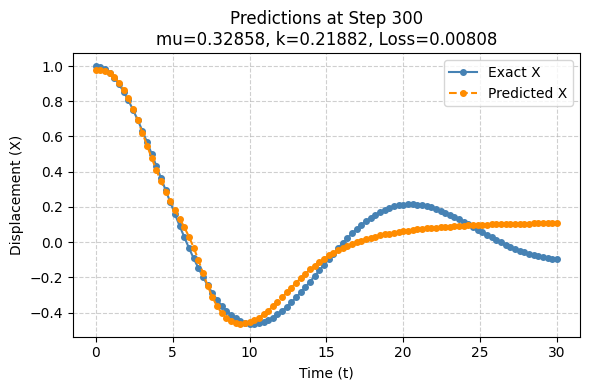

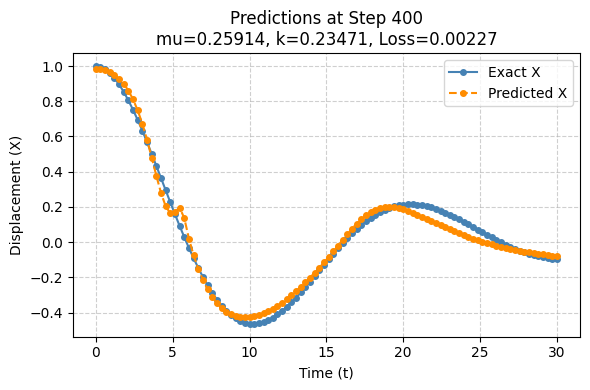

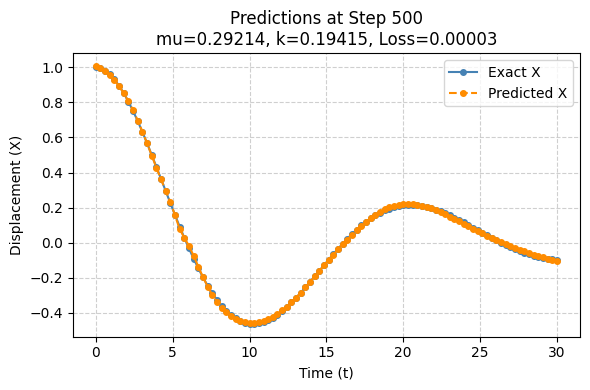

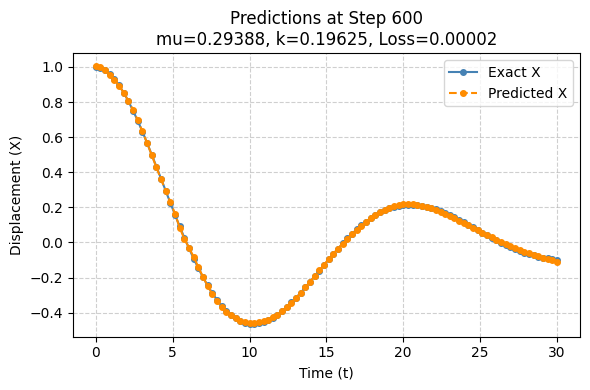

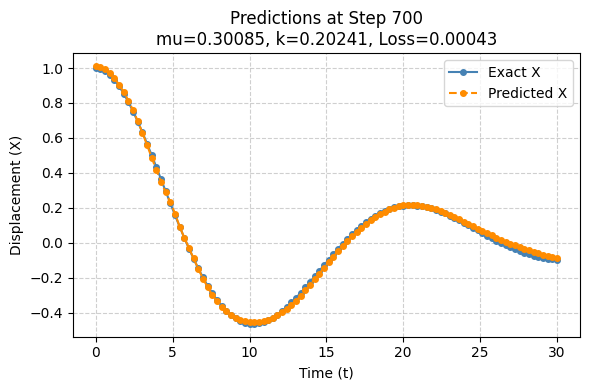

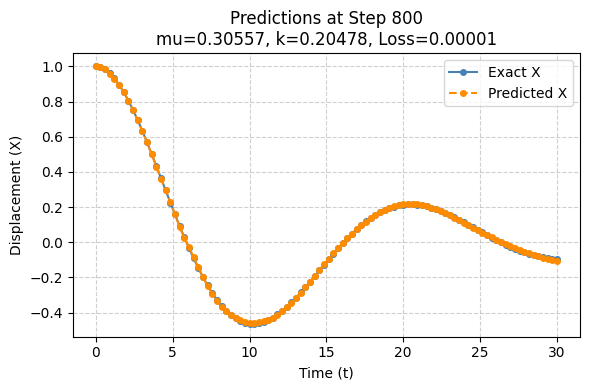

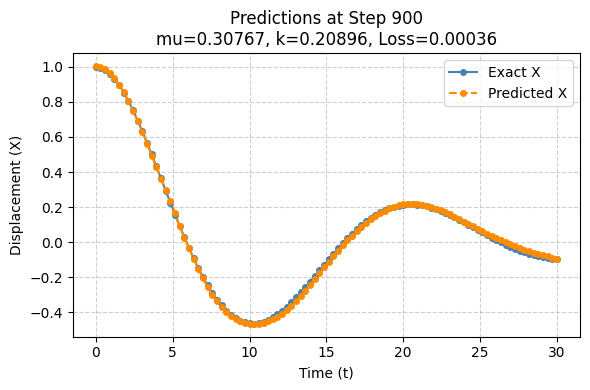

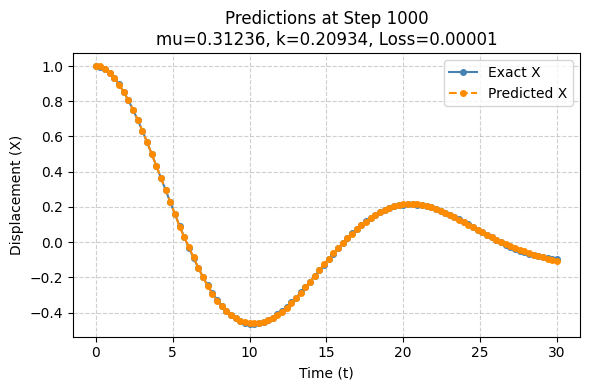

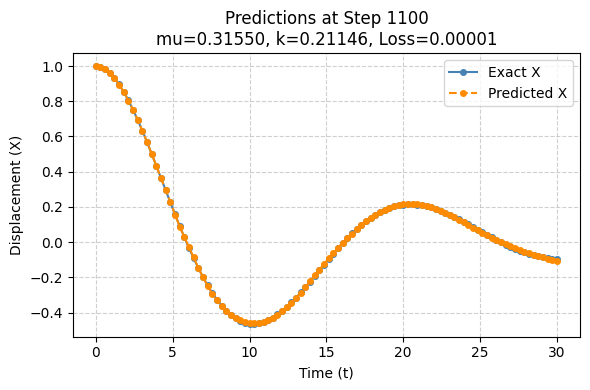

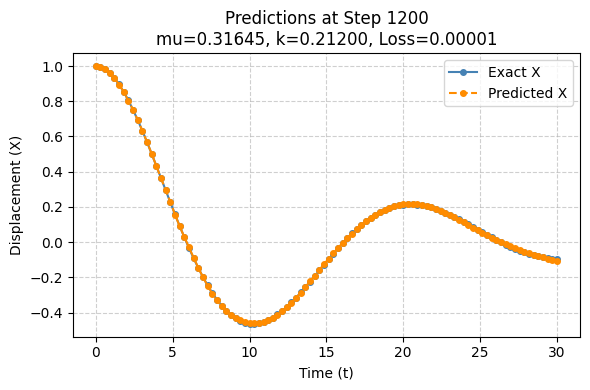

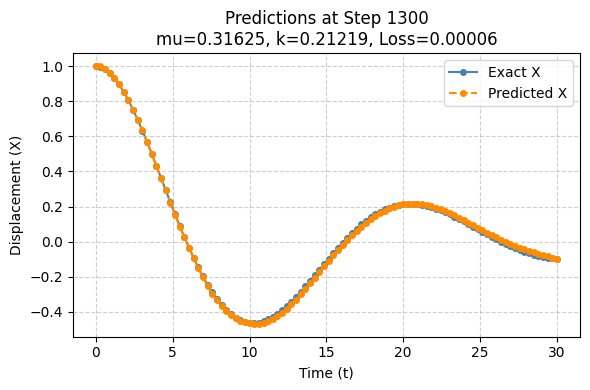

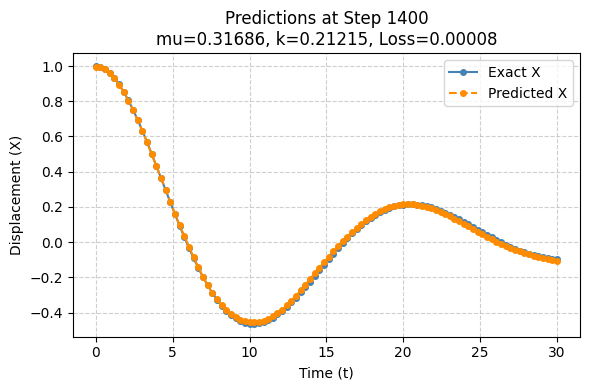

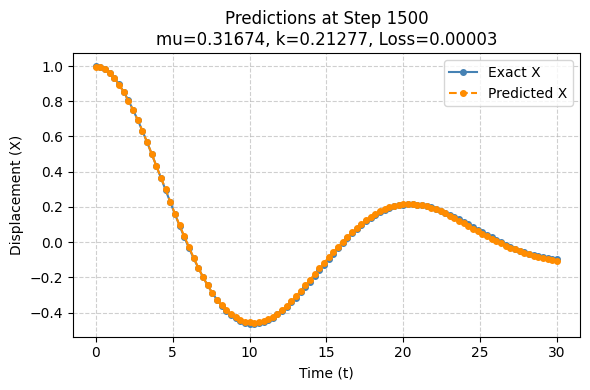

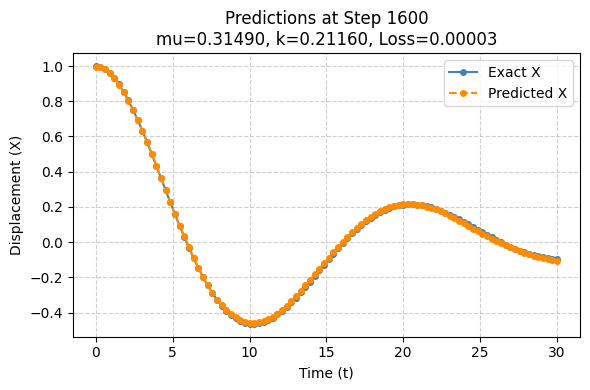

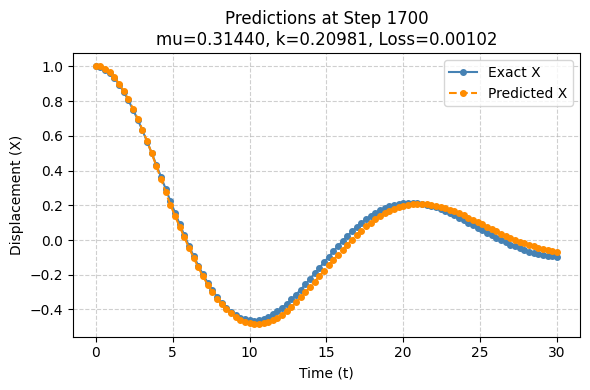

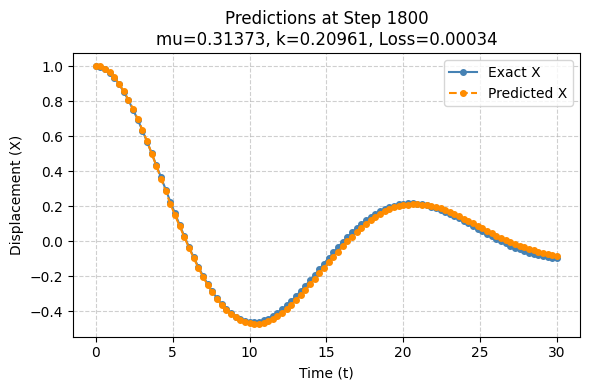

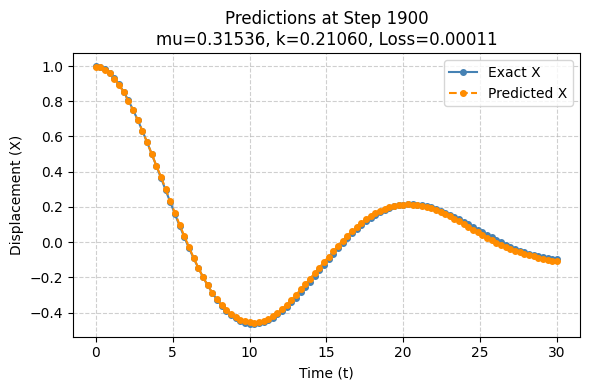

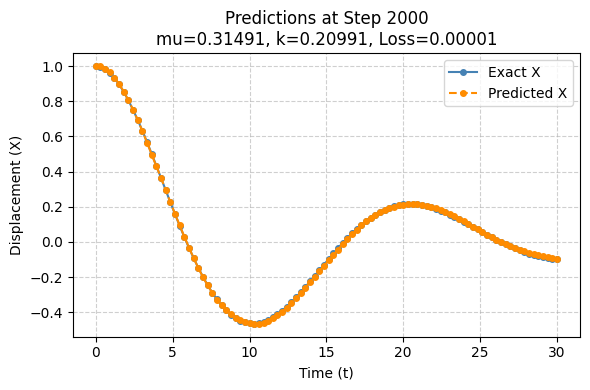

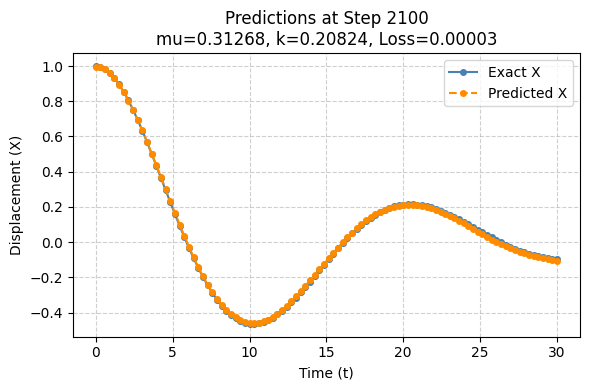

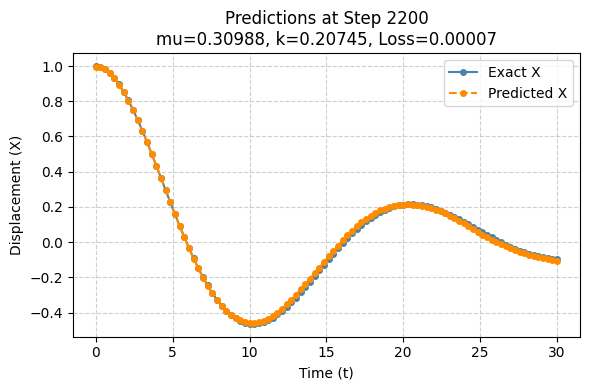

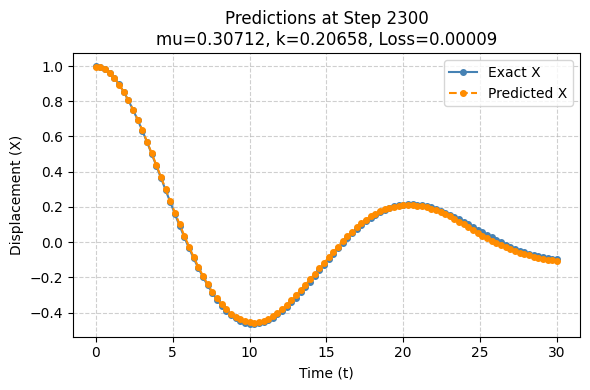

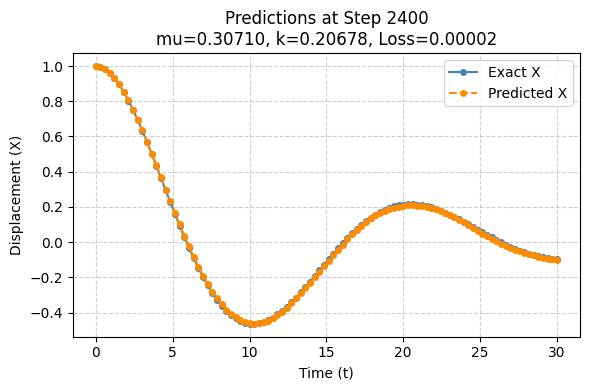

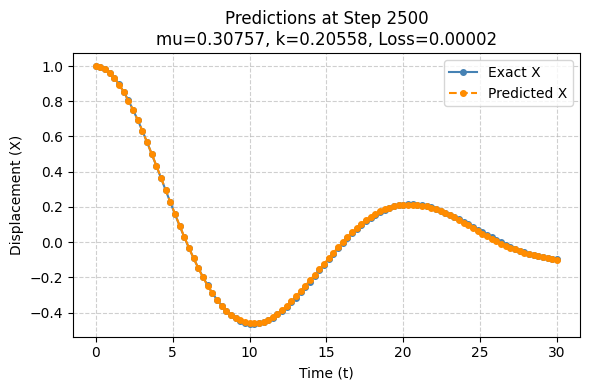

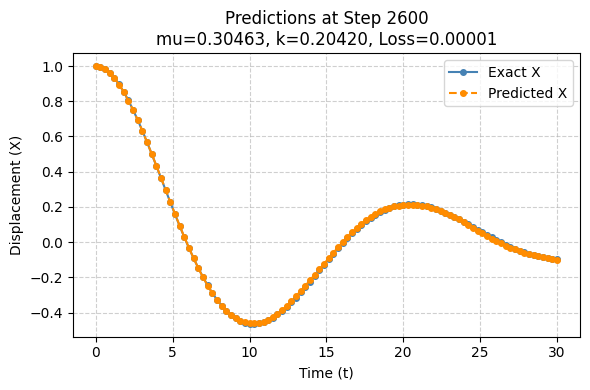

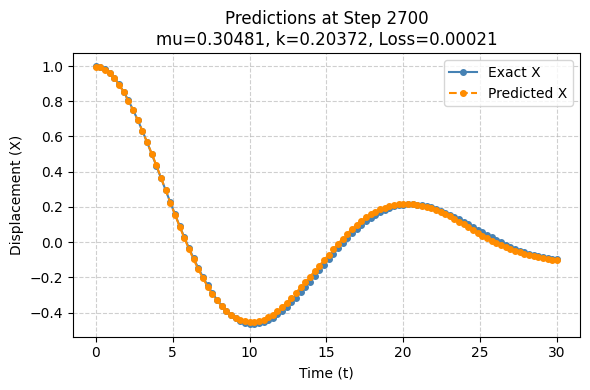

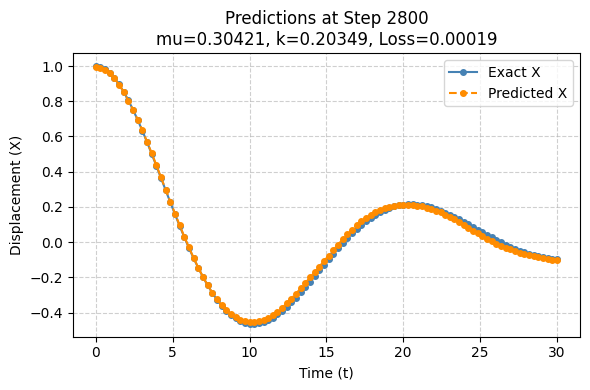

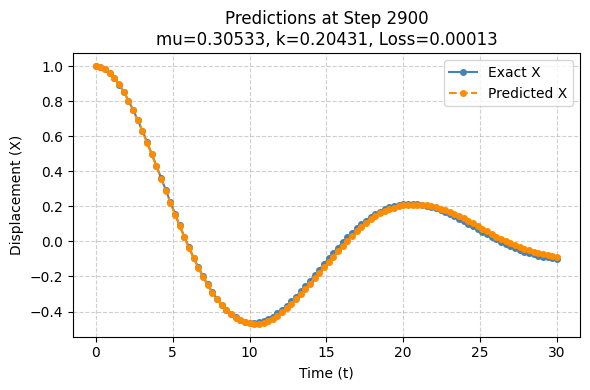

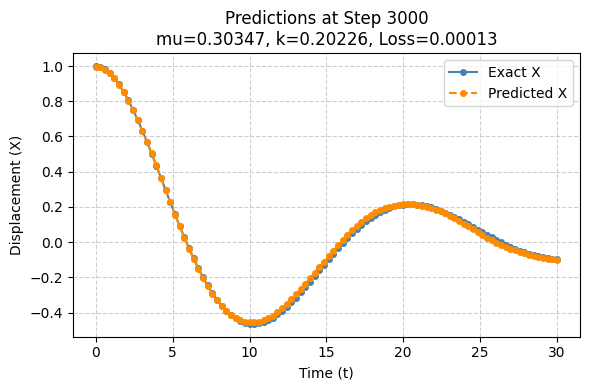

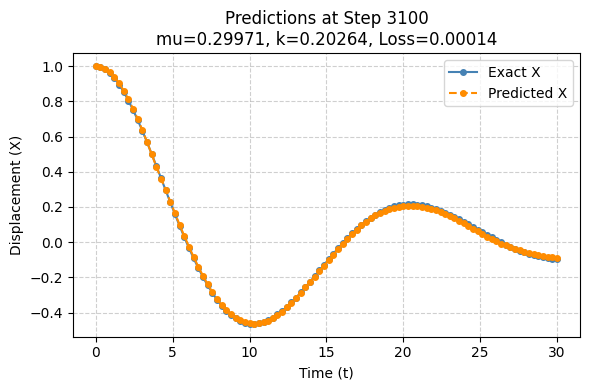

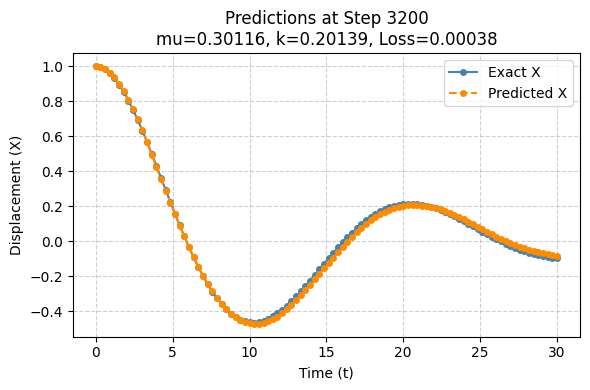

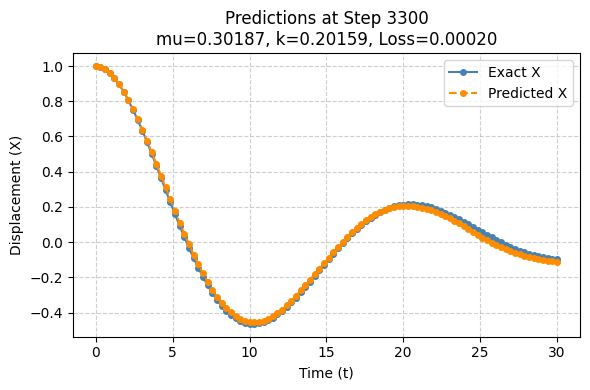

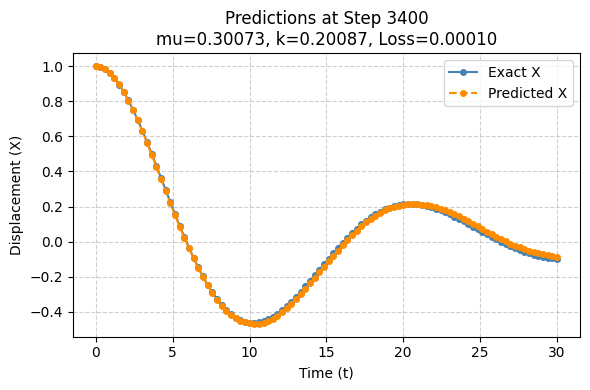

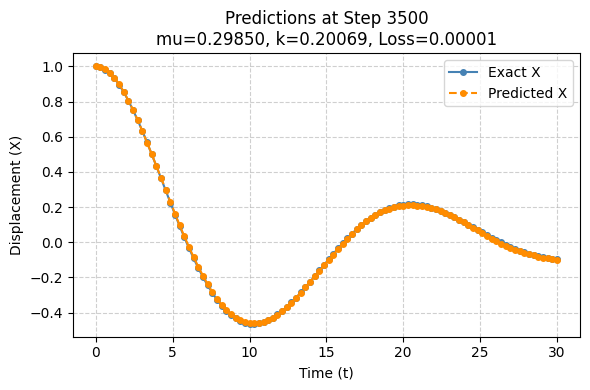

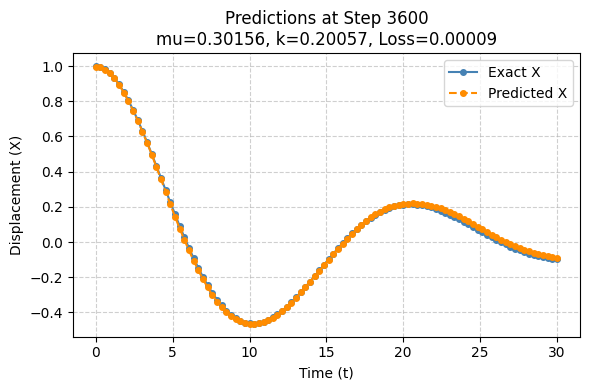

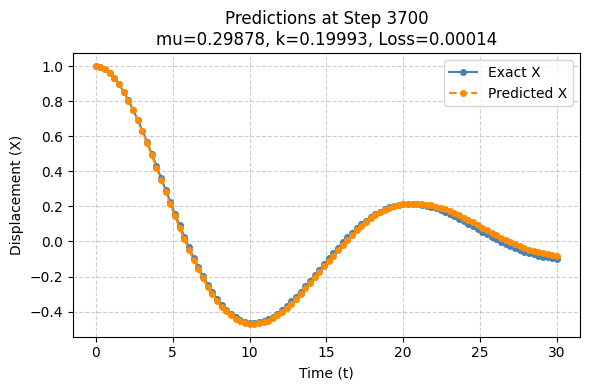

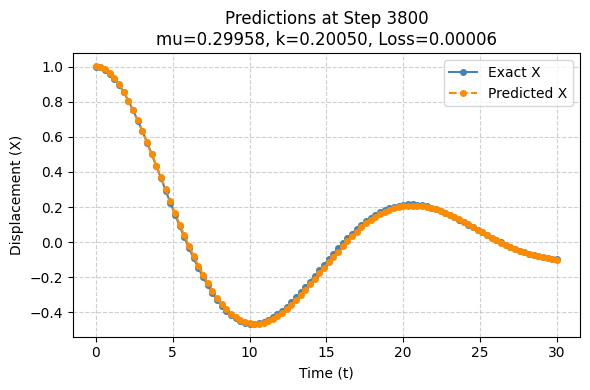

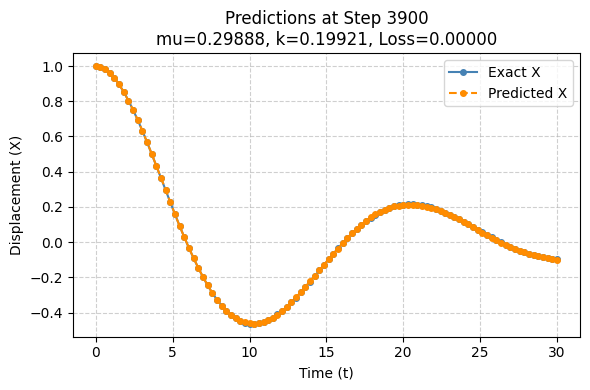

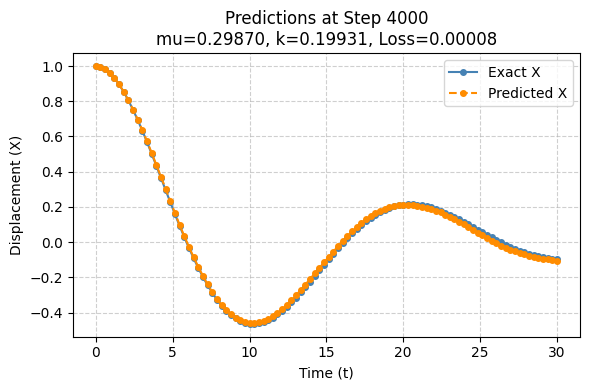

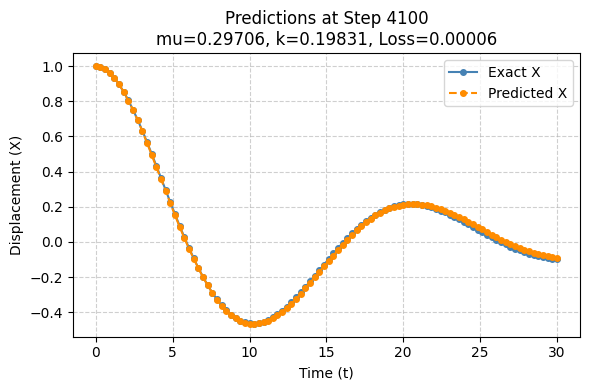

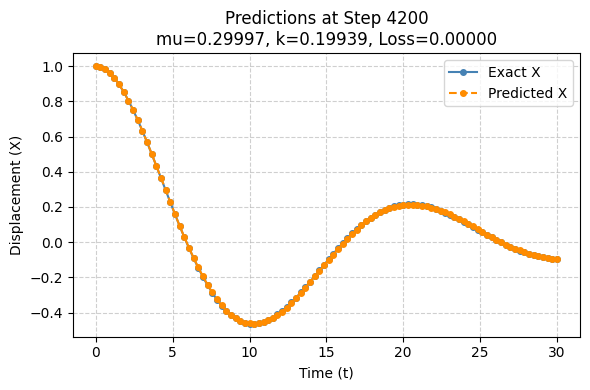

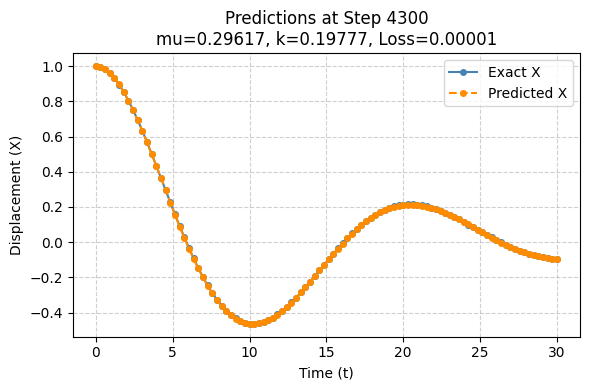

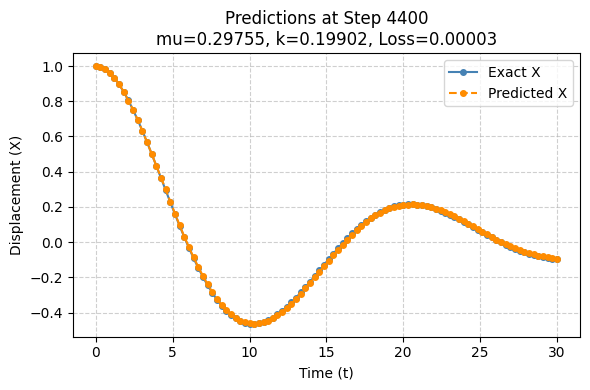

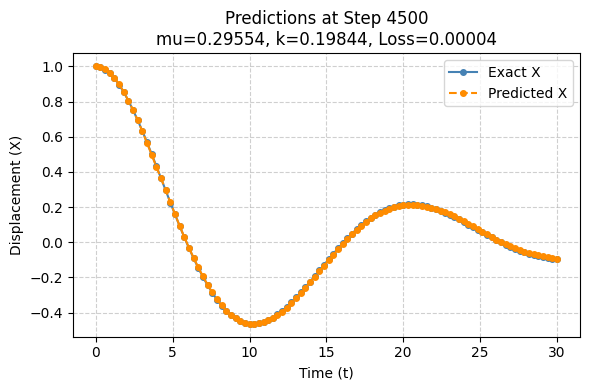

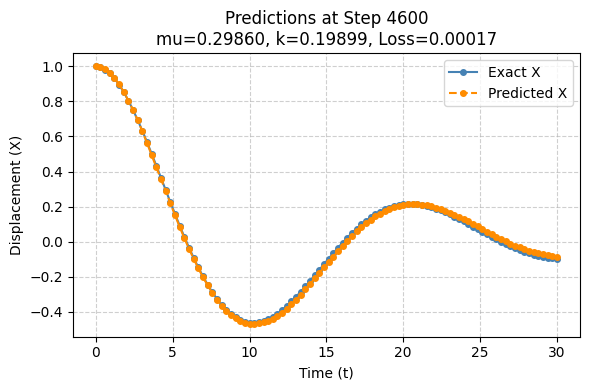

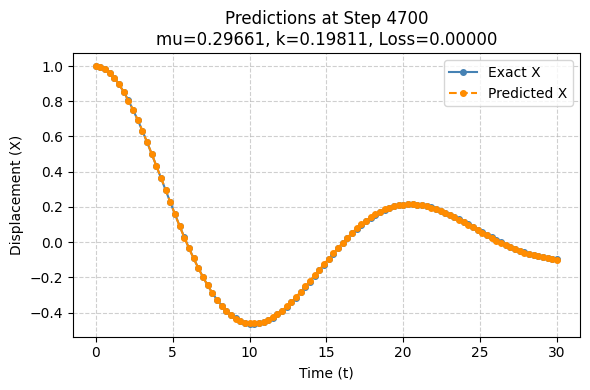

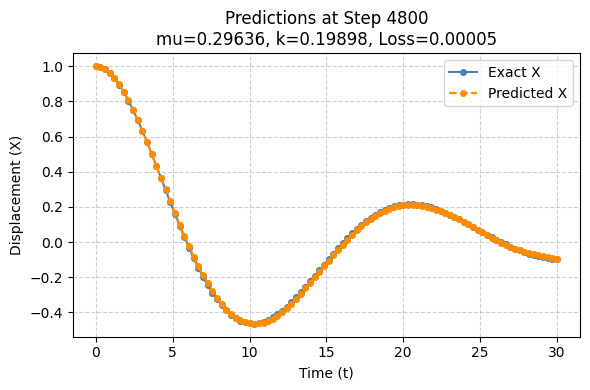

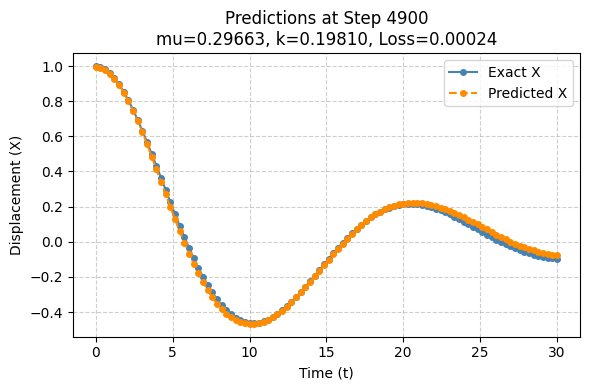

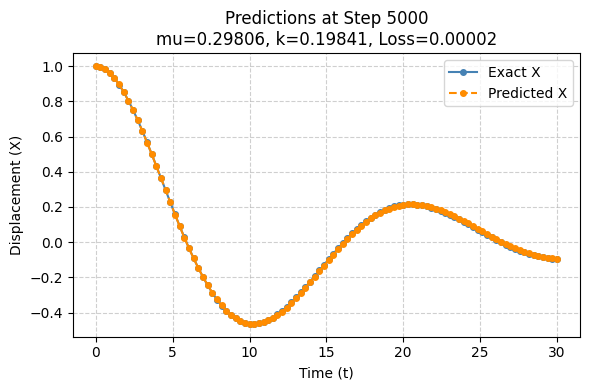

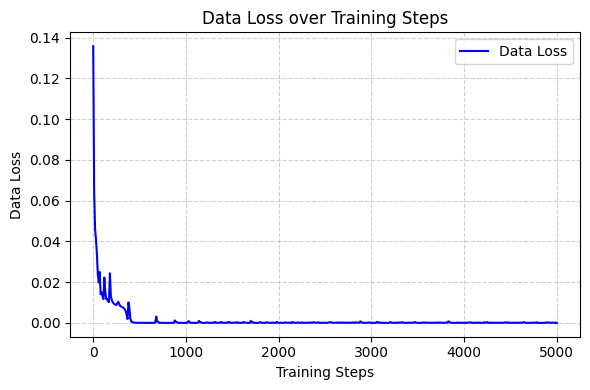

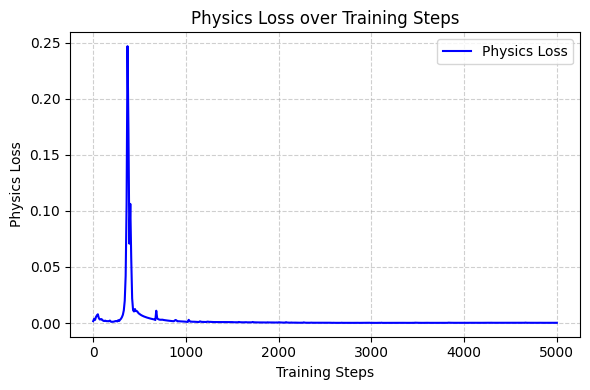

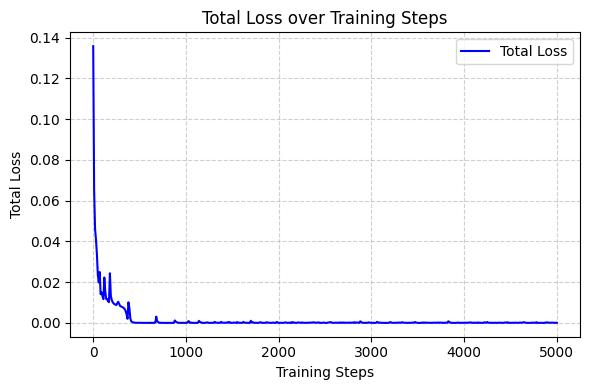

🏆 Final Estimates: mu=0.29806, k=0.19841, Fixed Parameters: m=2


In [10]:
best_params={'n_hidden': 31, 'n_layers': 5, 'lambda1': 0.00038112911474038854, 'learning_rate': 0.007430756814760012}
# Train the model with best parameters
print("📈 Training final model with best parameters and plotting results...")
_, estimated_values = pinn_training(t, x, fixed_params, **best_params, epochs=5000, plot=True)

# Final parameter estimates
estimated_params_str = ", ".join([f"{key}={val:.5f}" for key, val in estimated_values.items()])
fixed_params_str = ", ".join([f"{key}={val}" for key, val in fixed_params.items()])
print(f"🏆 Final Estimates: {estimated_params_str}, Fixed Parameters: {fixed_params_str}")

## Inverse Solution In range tesing and out of range testing

Initial Conditions: X0=1.0, V0=0.0


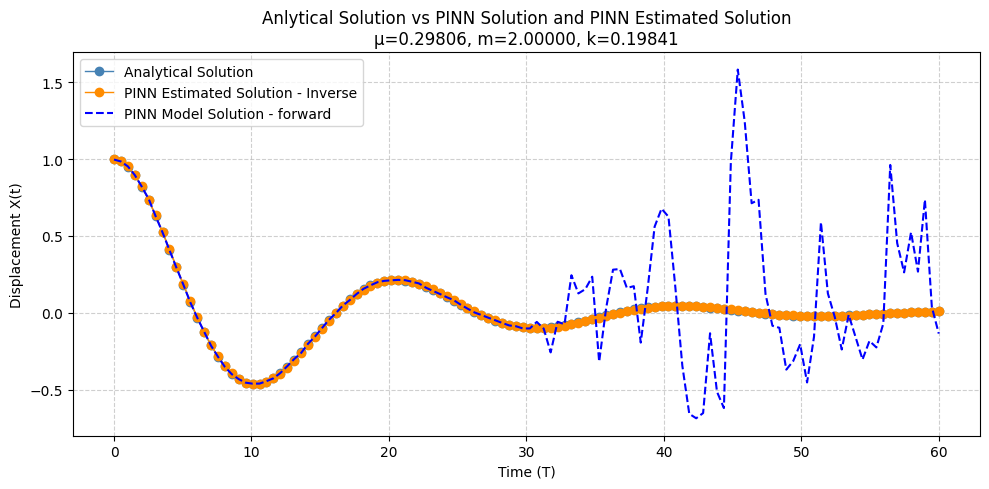

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def damped_oscillator(t, y, m, mu, k):
    x, v = y  # y[0] = x (displacement), y[1] = v (velocity)
    dxdt = v
    dvdt = -(mu/m) * v - (k/m) * x  # Equation: m*d2x/dt2 + μ*dx/dt + k*x = 0
    return [dxdt, dvdt]

# Function to predict X values for specific T values
def predict_x_values(m, mu, k, test_t, x0, v0):
    if len(test_t) == 0:
        raise ValueError("Test set T values are empty. Check test_df for proper data.")
    t_span = (test_t[0], test_t[-1])
    solution = solve_ivp(damped_oscillator, t_span, [x0, v0], args=(m, mu, k), t_eval=test_t)
    return solution.y[0] if len(solution.t) == len(test_t) else np.interp(test_t, solution.t, solution.y[0])


# Extract T values from the test set
test_t = test_df['Time'].values
if len(test_t) == 0:
    raise ValueError("No T values in the test set. Please check test_df.")

# Initial conditions:
x0 = test_df['Displacement'].iloc[0]  # Initial displacement
v0 = np.interp(0, train_df['Time'], train_df['Velocity'])  # Interpolating velocity at t=0

print(f"Initial Conditions: X0={x0}, V0={v0}")

#estimated values from PINN

m_estimate = 2
mu_estimate = 0.29806
k_fixed = 0.19841

# Predict X values for test set
predicted_x = predict_x_values(m_estimate, mu_estimate, k_fixed, test_t, x0, v0)

test_df['Predicted_Displacement'] = predicted_x

# Plot actual vs predicted displacement X(t)
plt.figure(figsize=(10, 5))
plt.plot(test_df['Time'], test_df['Displacement'], "o-", label="Analytical Solution", color="steelblue", linewidth=1)
plt.plot(test_df['Time'], test_df['Predicted_Displacement'], "o-", label="PINN Estimated Solution - Inverse", color="darkorange", linewidth=1)
plt.plot(test_df['Time'], test_df['PINN_Solution_Predicted_Displacement'], label='PINN Model Solution - forward', color='blue', linestyle='dashed')
plt.xlabel("Time (T)")
plt.ylabel("Displacement X(t)")
plt.title(f"Anlytical Solution vs PINN Solution and PINN Estimated Solution\nμ={mu_estimate:.5f}, m={m_estimate:.5f}, k={k_fixed:.5f}")
plt.legend()
plt.grid(visible=True, which="major", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Compute RMSE for both predicted and model-predicted values
rmse_predicted = calculate_rmse(test_df['Displacement'], test_df['PINN_Solution_Predicted_Displacement'])
rmse_model_inverse = calculate_rmse(test_df['Displacement'], test_df['Predicted_Displacement'])

print(f"RMSE for Forward Solution: {rmse_predicted:.5f}")
print(f"RMSE for Inverse Solution: {rmse_model_inverse:.6f}")


RMSE for Forward Solution: 0.33188
RMSE for Inverse Solution: 0.002793
